#Quantum Assisted Gaussian Process (QGP) Simulations

This work book endeavours to simular Quantum Assisted Gaussian Processes (http://arxiv.org/abs/1512.03929). The code simulates the variance induced by the quantum system when using naturally sparse kernels.


In [1]:
import sys
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import pyGPs

Populating the interactive namespace from numpy and matplotlib


## Kernels

We will use three kernels which lead to sparse covariance matrices. The first is from [MacKay](http://www.inference.eng.cam.ac.uk/mackay/gp.pdf):

$k(x,x')= 1 - |x-'x|/d,$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The second is from [Storkey](https://www.researchgate.net/profile/Amos_Storkey/publication/3835514_Truncated_covariance_matrices_and_Toeplitz_methods_in_Gaussian_processes/links/02bfe5120657a2b20f000000.pdf):

$k(x,x')= 1 + cos(|x-'x|/d),$ if $|x-'x|/d<\pi$

$k(x,x')= 0,$ otherwise

Finally, the third is from [Melkumyan](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI-09/paper/viewFile/630/840):

$k(x,x')= \frac{1 - cos(2\pi \frac{|x-'x|}{d})}{3}(1 - \frac{|x-'x|}{d}) + \frac{1}{2\pi}sin(2\pi \frac{|x-'x|}{d}),$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The latter two kernels have very similar properties to the gaussian kernel (also known as the square exponential or rbf kernel).

Each of these kernels may be multiplied by a constant $\sigma^2$ which can be optimised during training. We also note that adding i.i.d. noise does not effect the sparsity. This noise $\sigma_n^2$ will also be optimised.

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:211: RuntimeWarning: covariance is not positive-semidefinite.
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:213: RuntimeWarning: covariance is not positive-semidefinite.


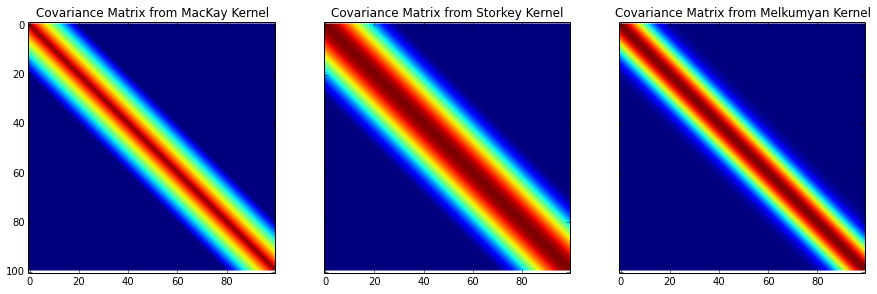

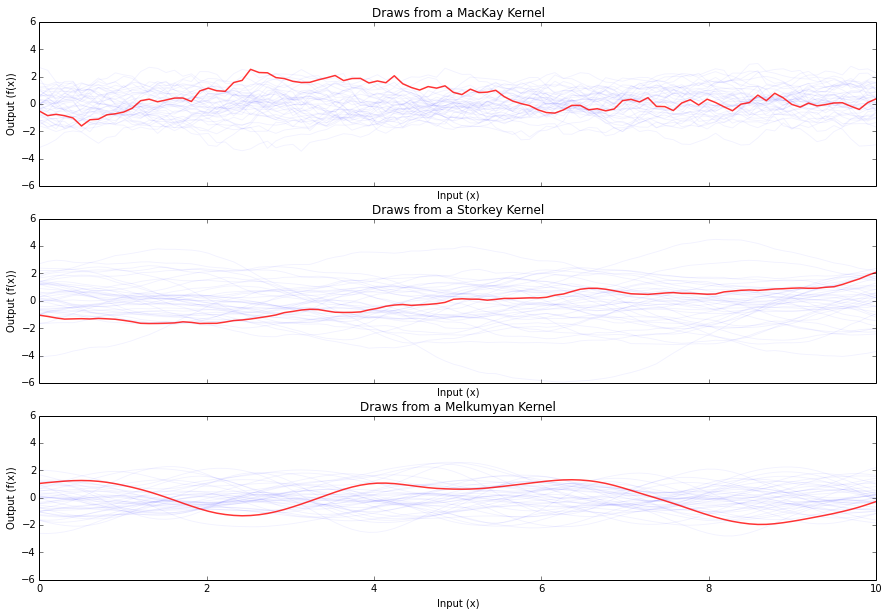

In [2]:
# Define the kernel functions

import scipy.spatial.distance as spdist

class kernel_mackay(pyGPs.Core.cov.Kernel):
    '''
    MacKay kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, D=12, log_ell=0., log_sigma=0.):
        self.hyp = [0. for i in range(D)] + [log_sigma]


    def getCovMatrix(self,x=None,z=None,mode=None):
        #self.checkInputGetCovMatrix(x,z,mode)
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        ell = np.exp(self.hyp[0:D])*2         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
        A[A>1] = 1.
        A = sf2 *(1. - A)
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        ell = np.exp(self.hyp[0:D])*2         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
                
        if der < D:    # compute derivative matrix wrt 1st parameter
            A[A>1] = 0.
            A = sf2 * A / ell[der]
        elif der == D:  # compute derivative matrix wrt 2nd parameter
            A[A>1] = 1.
            A = 2. * sf2 *(1. - A)
        else:
            raise Exception("Calling for a derivative in MacKay kernel that does not exist")
        return A

class kernel_storkey(pyGPs.Core.cov.Kernel):
    '''
    Storkey kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, D=12, log_ell=0., log_sigma=0.):
        self.hyp = [0. for i in range(D)] + [log_sigma]

    def getCovMatrix(self,x=None,z=None,mode=None):
        #self.checkInputGetCovMatrix(x,z,mode)
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        ell = np.exp(self.hyp[0:D])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
        A[A>np.pi] = np.pi
        A = sf2 *(1. + np.cos(A))
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        ell = np.exp(self.hyp[0:D])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
        
        if der < D:    # compute derivative matrix wrt 1st parameter
            A[A>np.pi] = 0.
            A = sf2 * A*sin(A)/ell[der]
        elif der == D:  # compute derivative matrix wrt 2nd parameter
            A[A>np.pi] = np.pi
            A = 2. * sf2 *(1. + np.cos(A))
        else:
            raise Exception("Calling for a derivative in Storkey kernel that does not exist")
        return A
    
class kernel_melkumyan(pyGPs.Core.cov.Kernel):
    '''
    Melkumyan kernel with isotropic distance measure. hyp = [log_ell, log_sigma]
    :param log_ell: characteristic length scale.
    :param log_sigma: signal deviation.
    '''
    def __init__(self, D=12, log_ell=0., log_sigma=0.):
        self.hyp = [0. for i in range(D)] + [log_sigma]

    def getCovMatrix(self,x=None,z=None,mode=None):
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        #self.checkInputGetCovMatrix(x,z,mode)
        ell = np.exp(self.hyp[0:D])*3         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for training set
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
        idx = np.where(A>=1.)
        A = sf2 *(((2 + np.cos(2*np.pi*A))*(1 - A)/3) + np.sin(2*np.pi*A)/(2*np.pi))
        A[idx] = 0.
        return A


    def getDerMatrix(self,x=None,z=None,mode=None,der=None):
        #self.checkInputGetDerMatrix(x,z,mode,der)
        if not x is None:
            n, D = x.shape
        if not z is None:
            nn, D = z.shape
        ell = np.exp(self.hyp[0:D])         # characteristic length scale
        sf2 = np.exp(2.*self.hyp[D])      # signal variance
        if mode == 'self_test':           # self covariances for the test cases
            nn,D = z.shape
            A = np.zeros((nn,1))
        elif mode == 'train':             # compute covariance matix for dataset x
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),x.T).T,'euclidean')
        elif mode == 'cross':             # compute covariance between data sets x and z
            A = spdist.cdist(np.dot(np.diag(1/ell),x.T).T,np.dot(np.diag(1/ell),z.T).T,'euclidean')
        
        if der < D:    # compute derivative matrix wrt 1st parameter
            idx = np.where(A>=1.)
             #-(4 d sin((pi d)/x) (pi (d-x) cos((pi d)/x)-x sin((pi d)/x)))/(3 x^3)
            A = sf2 * (-1) * (4*(A*ell[der])*sin(np.pi*A)*(np.pi*ell[der]*(A-1)*cos(np.pi*A)-ell[der]*sin(np.pi*A)))/(3*ell[der]**3)
            A[idx] = 0.
        elif der == D:  # compute derivative matrix wrt 2nd parameter
            idx = np.where(A>=1.)
            A = 2 * sf2 *(((2 + np.cos(2*np.pi*A))*(1 - A)/3) + np.sin(2*np.pi*A)/(2*np.pi))
            A[idx] = 0.
        else:
            raise Exception("Calling for a derivative in Melkumyan kernel that does not exist")
        return A
    
# Plot the kernels so we can see what we are working with

X = np.linspace(0, 10, 100).reshape(-1,1)

K_mackay = kernel_mackay(D=1)
K_storkey = kernel_storkey(D=1)
K_melkumyan = kernel_melkumyan(D=1)

K1 = K_mackay.getCovMatrix(X, mode='train')
K2 = K_storkey.getCovMatrix(X, mode='train')
K3 = K_melkumyan.getCovMatrix(X, mode='train')

f, (axa, axb, axc) = plt.subplots(1,3, sharex=True, sharey=True, figsize=[15,4.5])

axa.imshow(K1)
axa.set_title('Covariance Matrix from MacKay Kernel')

axb.imshow(K2)
axb.set_title('Covariance Matrix from Storkey Kernel')

axc.imshow(K3)
axc.set_title('Covariance Matrix from Melkumyan Kernel')

# Plot some draws from their function spaces

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=[15,10])

for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K1)
    ax1.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K1)
ax1.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax1.set_title('Draws from a MacKay Kernel')
ax1.set_xlabel('Input (x)')
ax1.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K2)
    ax2.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K2)
ax2.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax2.set_title('Draws from a Storkey Kernel')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K3)
    ax3.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K3)
ax3.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax3.set_title('Draws from a Melkumyan Kernel')
ax3.set_xlabel('Input (x)')
ax3.set_ylabel('Output (f(x))')

#QGP Simulation and Analytic Performance Bounds

In [3]:
%pylab inline
import matplotlib.pyplot as plt
sys.path.append('./Datasets')
import PythonScripts.loadData as loadData

print 'Choose a dataset:'
names = loadData.getDataSetNames()
for i, ds in enumerate(names):
    print i, ds
    
ds_num = input('select dataset to use by index ')

x_tr, x_te, y_tr, y_te = loadData.getDataSet(names[ds_num])

`%matplotlib` prevents importing * from pylab and numpy


Populating the interactive namespace from numpy and matplotlib
Choose a dataset:
0 abalone
1 wine quality (white)
2 roads
3 air quality
4 sea tempeture
5 agromet
select dataset to use by index 2


In [5]:
'''
Zero Mean, Unit Variance the dataset
'''

for i, y_ in enumerate(y_tr):
    my = np.mean(y_)
    sy = np.std(y_)
    y_te[i] = (y_te[i] - my)/sy
    y_tr[i] = (y_tr[i] - my)/sy
    
for i, x_ in enumerate(x_tr):
    mxx = np.max(x_, 0)
    mnx = np.min(x_, 0)
    x_te[i] = (x_te[i] - mnx)/(mxx - mnx)
    x_tr[i] = (x_tr[i] - mnx)/(mxx - mnx)


In [8]:
'''
Kernel Selection
'''

kernels = ['MacKay', 'Storkey', 'Melkumyan']

print 'Choose a kernel:'
for i, k in enumerate(kernels):
    print i, k
    
k_num = input('select kernel to use by index ')

if kernels[k_num] == 'MacKay':
    kern = kernel_mackay()+pyGPs.cov.Noise()
elif kernels[k_num] == 'Storkey':
    kern = kernel_storkey()+pyGPs.cov.Noise()
elif kernels[k_num] == 'Melkumyan':
    kern = kernel_melkumyan()+pyGPs.cov.Noise()

Choose a kernel:
0 MacKay
1 Storkey
2 Melkumyan
select kernel to use by index 2


In [13]:
'''
Perform Approximate Gaussian Process
'''

# To be filled with predictions, require for the Calculate Performance block
y_mean = []
y_var = []
nlml = []
times = []

for i in xrange(1):    
    # Training data
    x = x_tr[i].reshape(-1,2)
    y = y_tr[i]
    
    # Testing data
    x_ = x_te[i].reshape(-1,2)
    
    print x.shape, y.shape, x_.shape
    
    ### Algorithm Start
    
    model = pyGPs.GPR()
    
    model.optimizer = pyGPs.opt.BFGS(model)
    
    model.setPrior(kernel=kern)
    
    model.optimize(x,y)
    
    m, v, fm, fs2, ln = model.predict(x_)
    
    y_mean.append(m)
    y_var.append(v)
    nlml.append(n)
    
    ### Algorithm Finish


(1500, 2) (1000,) (1500, 2)


Exception: Can not use BFGS. Try other optimization methods

In [40]:
'''
Calculate Performance
'''

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

table = ListTable()
table.append(['<em>CV Fold</em>', '<em>RMSE</em>', '<em>NLML</em>', '<em>Predictive LL</em>'])

for i in xrange(4):
    
    # Calculate RMSE
    rmse = np.mean((y_mean[i] - y_te[i])**2)**0.5
    
    # Calculate Predictive LL
    pll = np.mean(-0.5*(y_mean[i] - y_te[i])**2/y_var[i] - 0.5*np.log(2*np.pi*y_var[i]))
    
    table.append([i, rmse, nlml[i], pll])
table

CV Fold,RMSE,NLML,Predictive LL,Wall Clock Time
0,0.999287226998,-2.0641645358,-1.623581124,1.01332402229
1,0.998388238074,-3.57391759439,-1.6208692447,1.01218795776
2,0.997973005453,-11.9306861943,-1.62331751667,1.01360607147
3,0.997238251748,-2.17977827002,-1.62036003043,1.01304316521


In [44]:
'''
Save Performance Results (Optional)
'''

import pickle
import os

name = raw_input('Enter name to be saved as:')
name = 'Results/'+name
if not os.path.isdir(name):
   os.makedirs(name)

pickle.dump( table, open( name+"/table.p", "wb" ) )
pickle.dump( y_mean, open( name+"/y_mean.p", "wb" ) )
pickle.dump( y_var, open( name+"/y_var.p", "wb" ) )


Enter name to be saved as:Demo
Results/Demotable.p
